# Implementing neural networks

Today, we're going to go through the process together of implementing a neural network for a simple regression problem.  Then I'm going to turn you loose to adapt this methodology to the MNIST problem.

We're going to use a new library to implement this network.  This library is called pytorch, and you can easily install it by following the installation instructions found [here](https://pytorch.org/get-started/locally/).  Why are we not using numpy?  We'll return to that in a moment.  However, torch actually behaves significantly like numpy in a variety of ways.  For example we can generate a synthetic dataset (rather similar to that from Homework 2) using some familiar commands:


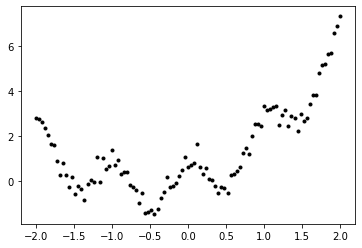

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Generate the features
x = torch.linspace(-2,2,101).reshape(-1,1)

# Generate the response variables 
y_obs = x**2 + x + torch.cos(2*np.pi*x) + torch.randn_like(x)*0.3

plt.plot(x,y_obs,'k.')

We'd like to find a function that fits this data.  One way to do this is, of course, linear regression, but that requires specifying the form of the design matrix.  As we saw in lecture, we'd like to learn the design matrix from the data.  We'll use a neural network to perform this task.  Algebraically, we can specify the neural network via the following sequentially applied functions.
$$
\underbrace{z}_{m\times p} = \underbrace{x}_{m\times 1} \underbrace{W^{(1)}}_{1\times p} + \underbrace{b^{(1)}}_{1\times p}
$$
$$
h = \sigma(z)
$$
$$
\underbrace{y}_{m\times 1} = h \underbrace{W^{(2)}}{p \times 1} + \underbrace{b^{(2)}}_{1\times 1}
$$

Because this is getting a bit complicated, let's develop a create a class for this neural network to hold weights and apply functions as appropriate.    

In [4]:
class NeuralNet(object):
    
    def __init__(self,n,p,N):
        self.n = n   # Number of features (1 for univariate problem)
        self.p = p   # Number of nodes in the hidden layer
        self.N = N   # Number of outputs (1 for the regression problem)
        
        # Instantiate weight matrices 
        self.W_1 = torch.randn(n,p)*10
        self.W_2 = torch.randn(p,N)/np.sqrt(p)
        
        # Instantiate bias vectors (Why do we need this?)
        self.b_1 = torch.randn(1,p)*10
        self.b_2 = torch.randn(1,N)/np.sqrt(p)
               
    def forward(self,X):
        # Applies the neural network model
        ## All of these self. prefixes save calculation results
        ## as class variables - we can inspect them later if we
        ## wish to
        self.X = X
        self.z = self.X @ self.W_1 + self.b_1  # First linear 
        self.h = torch.sigmoid(self.z)         # Activation
        self.y = self.h @ self.W_2 + self.b_2  # Second linear
        
        return self.y


You'll notice that we're instantiating weights randomly.  Let's see what type of functions this model produces, prior to training.  It's interesting to see what the effect is of messing with the variance of the weights when initializing them.   

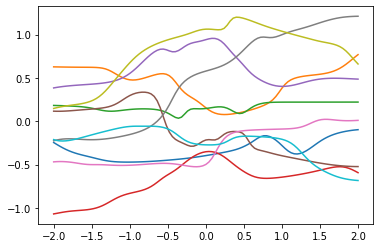

In [5]:
# Sample 10 random neural nets
for i in range(10):
    
    # Create the neural network
    net = NeuralNet(1,20,1)
    
    # Make a prediction
    y_pred = net.forward(x)
    
    # Plot the predictions
    plt.plot(x,y_pred)


Of course, this isn't all that interesting on its own.  We now need to train this thing.  We'll do this using gradient descent, and herein lies the power of pytorch.  It is a framework for *automatic differentiation*.  What does this mean?  It means that it keeps a record of all of the operations that have been done to produce the output of a given function.  It then can *automaticall* apply the chain rule to produce derivatives of a function with respect to anything that was used to compute it.  Here, we're hoping to take the gradient with respect to the weights and biases.  We can tell pytorch that we're going to want these things by using the "requires_grad_" flag.  

In [17]:
class NeuralNet(object):
    
    def __init__(self,n,p,N):
        self.n = n   # Number of features (1 for univariate problem)
        self.p = p   # Number of nodes in the hidden layer
        self.N = N   # Number of outputs (1 for the regression problem)
        
        # Instantiate weight matrices 
        self.W_1 = torch.randn(n,p)*10
        self.W_2 = torch.randn(p,N)/np.sqrt(p)
        
        # Instantiate bias vectors (Why do we need this?)
        self.b_1 = torch.randn(1,p)*10
        self.b_2 = torch.randn(1,N)/np.sqrt(p)
        
        ### CHANGE FROM ABOVE ###  
        # Collect the model parameters, and tell pytorch to
        # collect gradient information about them.
        self.parameters = [self.W_1,self.W_2,self.b_1,self.b_2]
        for param in self.parameters:
            param.requires_grad_()
    def forward(self,X):
        # Applies the neural network model
        ## All of these self. prefixes save calculation results
        ## as class variables - we can inspect them later if we
        ## wish to
        self.X = X
        self.z = self.X @ self.W_1 + self.b_1  # First linear 
        self.h = torch.sigmoid(self.z)         # Activation
        self.y = self.h @ self.W_2 + self.b_2  # Second linear
        return self.y
    
    def zero_grad(self):
        ### Each parameter has an additional array associated
        ### with it to store its gradient.  This is not 
        ### automatically cleared, so we have a method to
        ### clear it.
        for param in self.parameters:
            try:
                param.grad.data[:] = 0.0
            except AttributeError:
                pass
        

One thing that still need is something to minimize.  Since this is a regression problem, we'll use mean-squared-error

In [18]:
def mse(y_pred,y_obs):
    m = y_pred.shape[0]
    return 1./m*((y_pred-y_obs)**2).sum()

Now, the code for gradient descent becomes strikingly simple:

In [26]:
net = NeuralNet(1,20,1)  # Instantiate network
eta = 1e-1               # Set learning rate (empirically derived)
for t in range(50000):   # run for 50000 epochs
    y_pred = net.forward(x)   # Make a prediction
    L = mse(y_pred,y_obs)     # Compute mse
    net.zero_grad()           # Clear gradient buffer
    L.backward()              # MAGIC: compute dL/d parameter
    for param in net.parameters:            # update parameters w/
        param.data -= eta*param.grad.data   # GD
        
    if t%100==0:         # Print loss    
        print(t,L.item())
    
        


0 6.327963352203369
100 0.7425065636634827
200 0.6396632194519043
300 0.5689479112625122
400 0.5060304403305054
500 0.460988849401474
600 0.42912253737449646
700 0.4025101661682129
800 0.3807024359703064
900 0.36316120624542236
1000 0.3484952449798584
1100 0.3358146548271179
1200 0.3246138393878937
1300 0.31454163789749146
1400 0.3053252398967743
1500 0.2967434525489807
1600 0.28860917687416077
1700 0.28075501322746277
1800 0.2730214297771454
1900 0.2652450203895569
2000 0.257249116897583
2100 0.24884004890918732
2200 0.23981407284736633
2300 0.22998978197574615
2400 0.21928159892559052
2500 0.20780961215496063
2600 0.19598093628883362
2700 0.18442487716674805
2800 0.17375291883945465
2900 0.1643083244562149
3000 0.15610913932323456
3100 0.14898225665092468
3200 0.14272257685661316
3300 0.13716816902160645
3400 0.13220779597759247
3500 0.12776359915733337
3600 0.12377595156431198
3700 0.12019596248865128
3800 0.11698014289140701
3900 0.11408987641334534
4000 0.1114901602268219
4100 0.1

33100 0.06858240813016891
33200 0.06857575476169586
33300 0.06856920570135117
33400 0.06856264173984528
33500 0.06855621188879013
33600 0.0685497522354126
33700 0.06854325532913208
33800 0.06853688508272171
33900 0.06853050738573074
34000 0.06852435320615768
34100 0.06851804256439209
34200 0.06851185113191605
34300 0.0685056671500206
34400 0.06849945336580276
34500 0.0684933215379715
34600 0.06848730146884918
34700 0.06848128139972687
34800 0.06847531348466873
34900 0.06846926361322403
35000 0.06846338510513306
35100 0.0684574544429779
35200 0.06845156103372574
35300 0.06844566017389297
35400 0.06843987852334976
35500 0.06843411922454834
35600 0.06842834502458572
35700 0.06842260807752609
35800 0.06841689348220825
35900 0.06841122359037399
36000 0.06840553879737854
36100 0.06840001046657562
36200 0.06839442998170853
36300 0.0683889165520668
36400 0.06838338077068329
36500 0.06837785989046097
36600 0.06837247312068939
36700 0.06836704909801483
36800 0.06836160272359848
36900 0.068356223

Now we can plot our model prediction versus observations.  Pretty good!  And no manual selection of basis functions.

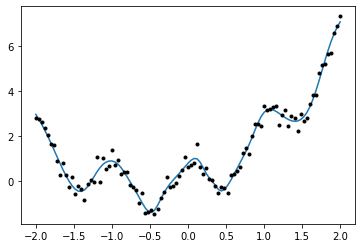

In [28]:
plt.plot(x.detach().squeeze(),y_pred.detach().squeeze())
plt.plot(x.detach().squeeze(),y_obs.detach().squeeze(),'k.')

# Your task:
Train a neural on MNIST using pytorch.  You should use the above code as a template.  Things you'll need to change: $n$ will no longer be 1, but rather 784.  $N$ will no longer be one, but 10.  You'll want to adjust $p$, the number of hidden layer nodes.  You'll likely need to adjust the learning rate.  Finally, and most importantly, you'll need to use a different loss function.  In particular, you'll replace our handrolled MSE code with [this](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).  IMPORTANT NOTE: this loss expects *logits* as inputs, which is to say that it will do softmax for you internally.  As such, the architecture of your network should be more or less the same as above.  